In [1]:
import os

# this get our current location in the file system
import inspect
HERE_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))

import random
import numpy as np

import tools
import embedding_tools

# adding openvault directory to path
import sys
openvault_path = os.path.join(HERE_PATH, '..')
sys.path.append(openvault_path)

from openvault.continuous import ContinuousLearner

from openvault_tools import SketchVaultPlayer
from openvault_tools import SketchVaultSignal

In [2]:
tools.set_seed(32)

sketch_root_folder = os.path.join(HERE_PATH, 'samples')
sketch_folders = tools.list_folders(sketch_root_folder)

type1_folder = random.choice(sketch_folders)

type2_folder = random.choice(sketch_folders)
while type2_folder == type1_folder:
    type2_folder = random.choice(sketch_folders)

print(type1_folder)
print(type2_folder)

type1_files = tools.list_files(type1_folder, ['*.json'])
type2_files = tools.list_files(type2_folder, ['*.json'])

Setting seed to 32
/Users/jgrizou/workspace/sketch_features/samples/triangles
/Users/jgrizou/workspace/sketch_features/samples/square


In [3]:
N_HYPOTHESIS = 10
player = SketchVaultPlayer(N_HYPOTHESIS, type1_files, type2_files)
player_signal = SketchVaultSignal()
learner = ContinuousLearner(N_HYPOTHESIS, 
                            proba_decision_threshold=0.99, 
                            proba_assigned_to_label_valid=0.95)

In [4]:
solved = []
correct = []
for j in range(30):
    flash_pattern = learner.get_next_flash_pattern(planning_method='even_uncertainty')

    sketch_file = player.get_sketch_file(flash_pattern)
    print(sketch_file)

    player_signal.add_feedback_sketch(sketch_file)
    
    feedback_signals, results = player_signal.get_feedback_signals()

    learner.signal_history = feedback_signals[:-1]
    learner.update(flash_pattern, feedback_signals[-1])

    #
    valid = False
    solved.append(learner.is_solved())
    if learner.is_solved():
        true_i_target = player.target_index
        found_i_target = learner.get_solution_index()
        print('{} - {} in {} steps'.format(true_i_target, found_i_target, j+1))
        valid = true_i_target == found_i_target

        # change target and propagate label for next target
        learner.propagate_labels_from_hypothesis(found_i_target)
        player.update_target_index()

    correct.append(valid)

/Users/jgrizou/workspace/sketch_features/samples/triangles/0030.json
/Users/jgrizou/workspace/sketch_features/samples/square/0030.json
/Users/jgrizou/workspace/sketch_features/samples/triangles/0026.json
/Users/jgrizou/workspace/sketch_features/samples/square/0026.json
/Users/jgrizou/workspace/sketch_features/samples/square/0006.json
/Users/jgrizou/workspace/sketch_features/samples/triangles/0006.json
/Users/jgrizou/workspace/sketch_features/samples/triangles/0010.json
/Users/jgrizou/workspace/sketch_features/samples/square/0010.json
/Users/jgrizou/workspace/sketch_features/samples/square/0047.json
/Users/jgrizou/workspace/sketch_features/samples/triangles/0047.json
/Users/jgrizou/workspace/sketch_features/samples/triangles/0046.json
7 - 7 in 11 steps
/Users/jgrizou/workspace/sketch_features/samples/square/0046.json
/Users/jgrizou/workspace/sketch_features/samples/triangles/0011.json
/Users/jgrizou/workspace/sketch_features/samples/square/0011.json
/Users/jgrizou/workspace/sketch_featu

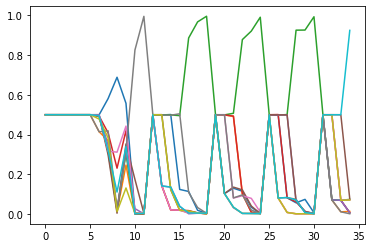

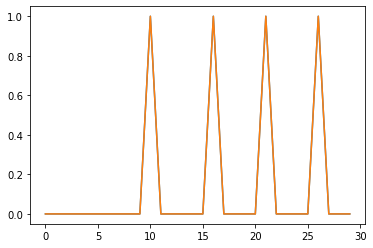

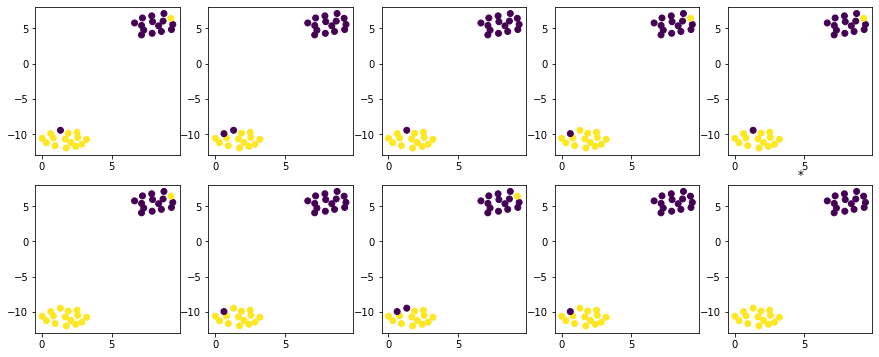

In [6]:
import matplotlib
import matplotlib.pyplot as plt
plt.ion()

plt.close('all')

plt.figure()
plt.plot(learner.hypothesis_probability_history)

plt.figure()
plt.plot(solved)
plt.plot(correct)



X_scatter = np.array(feedback_signals)

plt.figure(figsize=(15, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    plt.scatter(X_scatter[:,0], X_scatter[:,1], c=learner.hypothesis_labels[i])
    if i == player.target_index:
        plt.title('*')